Notebook for Problem Set 4
- **Authors:** Erin Silver, Sarah Grobe, Sarah Niknaum
- **Term:** Spring 2023
- **License:** GPL-3

In [220]:
'Network tools and basic functions for later use. Clean up regularly.'

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import ipywidgets as widgets
import random
import pandas as pd

In [266]:
def draw_network(G, colors = '#169'):
  pos = nx.get_node_attributes(G, "pos")
  nx.draw(G, pos=pos,
          node_size=[100 * G.degree(v) for v in G.nodes()],
          edgecolors='#333',
          cmap = plt.cm.Set3,
          node_color=colors,
          edge_color="#999")

# 1. Linear Rankings

## Data Acquisition

In [161]:
def load_nodes(G, filename):
    '''Loads nodes, metadata.'''
    vert_f = open(filename, 'r')
    vert_l = vert_f.readlines()[1:] # Skip header
    for v in vert_l:
        vert = v.rstrip('\n').split(',')
        pos_0 = float(vert[1].lstrip('"array(['))
        pos_1 = float(vert[2].lstrip(' ').rstrip('"])""'))
        pos = (pos_0, pos_1)
        G.add_node(int(vert[0]), pos=pos)

def load_edges(G, filename):
    '''Loads edges, metadata.'''
    edge_f = open(filename, 'r')
    edge_l = edge_f.readlines()[1:] # Skip header
    for e in edge_l:
        edge = e.rstrip('\n').split(',')  
        G.add_edge(int(edge[0]), int(edge[1]))

def load_csv(G, location):
    fn_nodes = location + '\\nodes.csv'
    fn_edges = location + '\edges.csv'
    load_nodes(G, fn_nodes)
    load_edges(G, fn_edges) 

In [162]:
G = nx.DiGraph()
load_csv(G, 'papuan')

C:\Users\Erin School\AppData\Roaming\Python\Python310\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


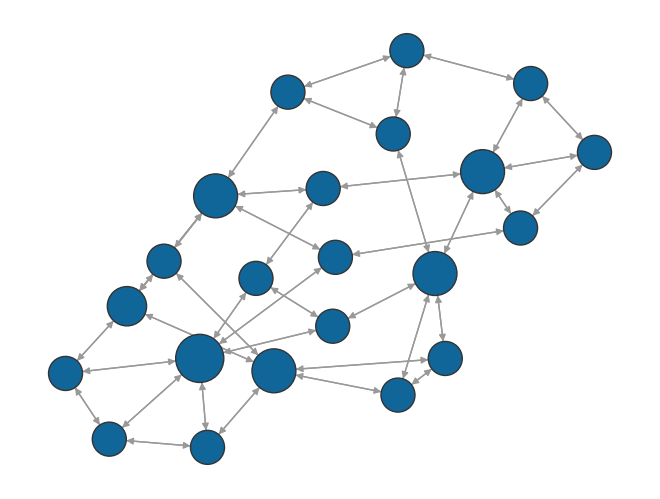

In [267]:
draw_network(G)

While this network is directed, all relationships appear to be reciprocal.

## Ranking top nodes with matrices

In [164]:
def get_katz_cent(G, a = 0.1):
    A = nx.adjacency_matrix(G).todense()
    n = A.shape[0]
    I = np.eye(n)
    centrality = np.matmul(np.linalg.inv(I - a*A), np.ones((n, 1)))
    return centrality.flatten()


In [165]:
def get_eigen_cent(G):
    A = nx.adjacency_matrix(G).todense()
    e_vals, e_vecs = np.linalg.eig(A)
    # get index of largest eigenvalue to pass and find matching eigenvector
    max_idx = np.argmax(e_vals)
    v = e_vecs[:, max_idx].real
    return v / np.sum(v)

In [166]:
def get_pr_cent(G, a = 0.85, max_iter = 100, tol = 1e-6):
    A = nx.adjacency_matrix(G).todense()
    n = A.shape[0]
    out_degree = np.sum(A, axis=1)
    P = A / out_degree[:, np.newaxis]
    v = np.ones(n) / n
    r = v.copy()

    for i in range(max_iter):
        r_new = a * P.T @ r + (1 - a) * v
        if np.linalg.norm(r_new - r) < tol:
            break
        r = r_new
    return r

In [ ]:
custom_katz = get_katz_cent(G)
custom_eigen = get_eigen_cent(G)
custom_pr = get_pr_cent(G)

### Visualization step

In [236]:
print(max(custom_eigen))

0.07391942645540177


In [237]:
def top_fives(cents):
    idxs = np.argpartition(cents, -5)[-5:]
    return idxs[np.argsort(cents[idxs])][::-1]

In [238]:
top_katz = top_fives(custom_katz)
top_eigen = top_fives(custom_eigen)
top_pr = top_fives(custom_pr)

In [241]:
table = np.transpose([top_katz, custom_katz[top_katz], 
         top_eigen, custom_eigen[top_eigen], 
         top_pr, custom_pr[top_pr]])
df = pd.DataFrame(table, columns = ['Node', 'Katz', 'Node', 'Eigen. Ctr.', 'Node', 'PageRank'],
                  index = ['1st', '2nd', '3rd', '4th', '5th'])
print(df)

     Node      Katz  Node  Eigen. Ctr.  Node  PageRank
1st   3.0  1.903872   3.0     0.073919   3.0  0.072897
2nd  16.0  1.776555   2.0     0.066455  17.0  0.062584
3rd   2.0  1.770237   7.0     0.059935  16.0  0.061798
4th  17.0  1.769429   5.0     0.059661   7.0  0.061709
5th   7.0  1.766012  16.0     0.057891   2.0  0.060970


In [264]:
def draw_ranks(G, top_five):
    ranks = [0 for n in range(len(G.nodes()))]
    for i in range(5):
        ranks[top_five[i]] += (5 - i)
    
    draw_network(G, colors = ranks)

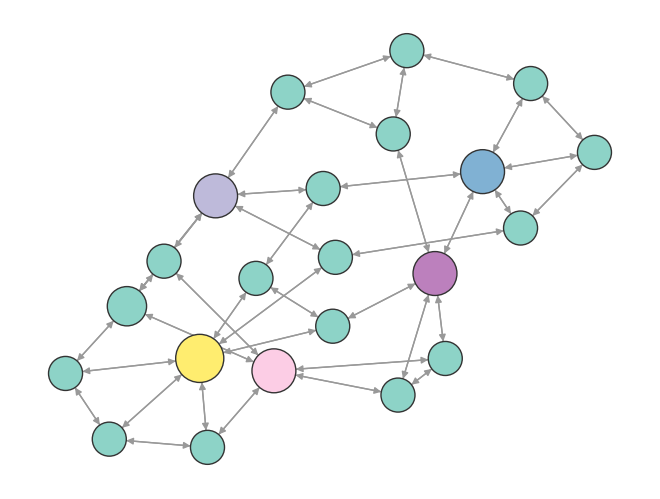

In [269]:
draw_ranks(G, top_katz)

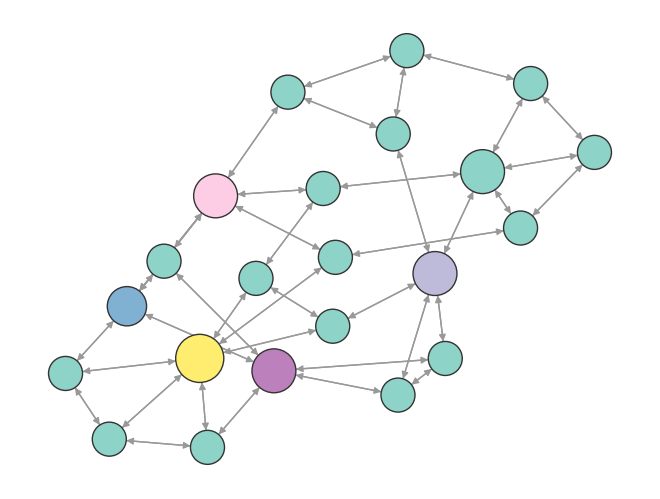

In [268]:
draw_ranks(G, top_eigen)

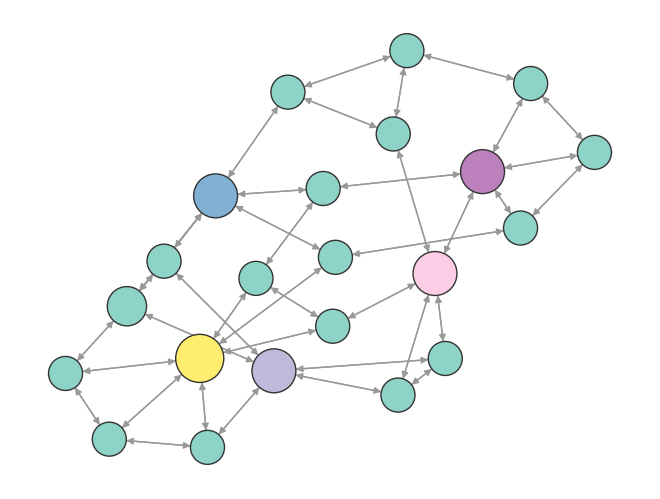

In [270]:
draw_ranks(G, top_pr)

## Verification

In [167]:
nx_katz = list(nx.katz_centrality(G).values())

const_katz = [(custom_katz[n] / nx_katz[n]) for n in range(len(G.nodes()))]
print(const_katz)

var_katz = np.var(const_katz)
print(var_katz)

[7.382650085677936, 7.382650007085795, 7.382650265585512, 7.3826503115338, 7.382650049948975, 7.382650209664897, 7.382650085827706, 7.382650135075992, 7.382649992034732, 7.382649992034732, 7.382649642261193, 7.382649968670023, 7.382649889934146, 7.382649483462006, 7.382649632184217, 7.382649582477576, 7.382650089142744, 7.382649943229882, 7.382650016348572, 7.382649633907334, 7.382649719136174, 7.382649945925874]
5.0585355182376815e-14


In [168]:
nx_eigen = list(nx.eigenvector_centrality(G).values())

const_eigen = [(custom_eigen[n] / nx_eigen[n]) for n in range(len(G.nodes()))]
print(const_eigen)

var_eigen = np.var(const_eigen)
print(var_eigen)

[0.22150403640990945, 0.22150528557298005, 0.22150067869943557, 0.22150299578163132, 0.2215045204517997, 0.2215016002295035, 0.22150073898473957, 0.22149800281970647, 0.22149650079789251, 0.22149650079789251, 0.2214914138574466, 0.22149814242070062, 0.22149382248335814, 0.2214844055760559, 0.22148858589667572, 0.22148101526992142, 0.22149244149861608, 0.22148607202619375, 0.2214990262769256, 0.2214818543319678, 0.22148718964470812, 0.22149998876170812]
5.443066722605078e-11


In [169]:
nx_pr = list(nx.pagerank(G).values())

const_pr = [(custom_pr[n] / nx_pr[n]) for n in range(len(G.nodes()))]
print(const_pr)

var_pr = np.var(const_pr)
print(var_pr)

[1.0000328744073836, 1.0000265609523504, 1.000013258955963, 1.000016008028193, 1.0000281663661126, 1.0000214941495686, 1.0000211974318187, 0.9999927538115194, 1.000013179222355, 1.000013179222355, 0.999983006951077, 1.0000073785338446, 0.9999989251081767, 0.9999664349632821, 0.9999786827405732, 0.9999650667993023, 0.9999900929002526, 0.9999752911927652, 1.0000153884792615, 0.9999698907823877, 0.9999709997092293, 1.0000056677908598]
4.632896676095106e-10


As the above variances in scalar difference between the custom and NetworkX functions are exceedingly small, we determine they are within reasonable error bounds.

## Comparable rankings

In [294]:
# Setup for correlations

alphas = [0.15, 0.25,  0.5, 0.75, 0.85]
alphas_pr = {}

for a in alphas:
    alphas_pr[a] = get_pr_cent(G, a)

max_pr = get_pr_cent(G, 1)

In [295]:
alphas_corr = {}

for a in alphas:
    alphas_corr[a] = np.corrcoef(max_pr, alphas_pr[a])[1][0]

print(alphas_corr)

{0.15: 0.9798444198758787, 0.25: 0.9824978247949154, 0.5: 0.9884457551249689, 0.75: 0.9943206087665453, 0.85: 0.9968908998825603}


An increase in correlation between PageRank with damping factor alpha and PageRank with a damping factor of one appears to slightly follow an increase in alpha. We conclude that higher damping factors have only a slight impact.

## Alternative points of view

In [177]:
[r for r in G.neighbors(1)]

[0, 4, 3]

In [299]:
def random_walker(G, a = 0.85, steps = 10000):
    A = nx.adjacency_matrix(G).todense()
    n = A.shape[0]
    cts = dict(zip(G.nodes(), [0 for i in range(n)]))
    pos = random.choice(range(n)) # Start the walker at random ACTive node

    for i in range(steps):
        neighbors = [n for n in G.neighbors(pos)]
        if random.random() < (1 - a):
            pos = random.choice(range(n))
        else:
            pos = random.choice(neighbors)
        cts[pos] += 1

    return cts

### Correlation between random walker and PageRank

In [304]:
rw_pr = {}
for a in [0.25, 0.75, 0.85]:
    rw_pr[a] = [n for n in random_walker(G, a).values()]

rw_pr_corr = [np.corrcoef(alphas_pr[a], rw_pr[a])[1][0] for a in [0.25, 0.75, 0.85]]
print(rw_pr_corr)

[0.90393643028254, 0.9917909087962732, 0.9774023221432031]


For the random walk example, differences in the damping factor demonstrate a more pronounced change, in the same direction as the matrix-based calculation of PageRank.

In [ ]:
rw_pr_hk = {}
for a in [0.25, 0.75, 0.85]:
    rw_pr_hk[a] = [n for n in random_walker(G, a, 100000).values()]

rw_pr_hk_corr = [np.corrcoef(alphas_pr[a], rw_pr_hk[a])[1][0] for a in [0.25, 0.75, 0.85]]
print(rw_pr_hk_corr)